In [36]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [15]:
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2024, 12, 31)


In [16]:
df = pd.read_csv('GS3M.csv',parse_dates=['observation_date'])

Downloaded data from FRED as csv and loaded it.

In [17]:
df = df.dropna()

Dropping missing values.

In [18]:
r = df['GS3M'].values / 100

if len(r) < 2:
    raise ValueError("Not enough data points.")

Extracting interest rates and converting them to decimals. (Not a panda tool so cannoy use head on this). Then doing a safety check in the next line.

In [19]:
print(df.head)
print(r[:5])

<bound method NDFrame.head of     observation_date   GS3M
0         1981-01-09  15.61
1         1981-01-10  14.23
2         1981-01-11  11.35
3         1981-01-12  11.32
4         1982-01-01  12.92
..               ...    ...
520       2025-01-01   4.34
521       2025-01-02   4.33
522       2025-01-03   4.34
523       2025-01-04   4.32
524       2025-01-05   4.36

[525 rows x 2 columns]>
[0.1561 0.1423 0.1135 0.1132 0.1292]


Second line prints first five values.

OLS regression: r_{t+1} = alpha + beta * r_t + epsilon(error term), (r_{t+1}= α + βr_{t} +ε).

We're trying to predict tomorrow’s interest rate (r_tp1) using today’s interest rate (r_t), by finding the best-fitting line.


In [20]:
r_t = r[:-1]

Takes all elements of the array r except the last one, and is interest rate at time t.
Why?
Because the last value has no "tomorrow" to compare it to. If we want to understand how today’s value affects tomorrow’s, we can't use the final entry — there's nothing after it.

In [21]:
r_tp1 = r[1:]

Takes all elements of r except the first one (since the first index is 0), and is interest rate at time t+1.

This gives us the "next day" rates (r at time t+1), allowing us to pair them with today's rates (r[:-1]) for time series modeling like regression.

We need to pair today’s rate (r_t) with tomorrow’s rate (r_tp1) so we can learn the relationship between them — specifically, to model how the interest rate changes over time.

In [22]:
dt = 1 / 250

Defines the time step between observations, there are 250 trading days in a year, so each step is 1/250 of a year.


In [23]:
X = np.column_stack((np.ones(len(r_t)), r_t))
print(X)

[[1.     0.1561]
 [1.     0.1423]
 [1.     0.1135]
 ...
 [1.     0.0433]
 [1.     0.0434]
 [1.     0.0432]]


Builds a matrix X with two columns:
- The first column is all ones → this allows us to estimate an intercept (α).
- The second column is the actual data → r_t, the interest rate at time t.

Why it's needed:

OLS regression fits a line of the form:
y=α+βx

To compute this using matrix algebra, the intercept α must be part of the matrix — and that's why we include a column of 1s.




In [24]:
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ r_tp1

What it does:

Solves the matrix equation for the OLS estimator:

β^=(X^⊤*X)^−1* X^⊤y - this is the matrix formula (also can be seen in strong generalised matrixes topics)

Here:
- X is the input matrix (with ones and r_t)
- y (which is r_tp1) is the actual value we're trying to predict (r at time t+1)

Why this works:

This formula gives the best-fitting line by minimizing the sum of squared errors between predicted and actual r_tp1.

How it works in code:

X.T @ X: creates the normal matrix (multiplying it by its transpose)

np.linalg.inv(...): inverts the matrix

@ X.T @ r_tp1: multiplies to give the solution beta_hat, which contains both α and β.

In [25]:
alpha = beta_hat[0]
beta = beta_hat[1]

What it does:

Gets the values of α (intercept) and β (slope) from the solution vector beta_hat.

Why it works:

The structure of X ensures that the first element of beta_hat corresponds to the intercept, and the second to the slope.

In [26]:
predicted = X @ beta_hat

What it does:

Multiplies the input matrix X (with ones and r_t) by the estimated coefficients to get predicted values of r_tp1.

r_{t+1} =α+β⋅r_{t}

Why it works:

This is the same as plugging r_t into the regression equation.

How it works in code:

Matrix multiplication (@) applies the equation to every row.

In [27]:
residuals = r_tp1 - predicted

What it does:

Finds the difference between actual and predicted values — the errors.

ε = r_{t+1} − r^_{t+1}

Why it's important:

Residuals show how well the model fits. Large residuals mean poor predictions.



In [28]:
ss_res = np.sum(residuals**2)
ss_tot = np.sum((r_tp1 - np.mean(r_tp1))**2)
r_squared = 1 - (ss_res / ss_tot)

What it does:
- ss_res is the sum of squared residuals (how much the model got wrong)
- ss_tot is the total variation in r_tp1 (how spread out the real data is)
- r_squared is the fraction of variation explained by the model

R-Sqaured = 1 − SST/SSR

Why it works:

If your predictions are perfect, ss_res is 0 and R² is 1.

If your model is useless, ss_res = ss_tot and R² is 0.



In [29]:
print("alpha:", alpha)
print("beta:", beta)
print("R²:", r_squared)

alpha: 0.0004806366723439465
beta: 0.9818315556687266
R²: 0.9903166836716014


This simply shows the final output:

α: the baseline level of r_{t+1} when r_t = 0

β: how much r_{t+1} changes per 1 unit increase in r_t

R²: how well r_t explains r_{t+1}


The Vasicek model is:

dr(t) = a(b − r(t))dt + σdW(t)

The parameters are:

a: speed of mean reversion

b: long-term mean level

σ: volatility of the process

We estimate these from the OLS regression by rearranging.

In [30]:
if 0 < beta < 1:
    a = (1 - beta) / dt
    b = alpha / (1 - beta)
    sigma = np.std(residuals, ddof=1) / np.sqrt(dt)
else:
    raise ValueError("Beta outside (0,1): invalid for Vasicek estimation")

Checking if beta is in a valid range for Vasicek.


- a = (1 - β) / dt

  Converts the discrete autoregressive slope into a continuous-time mean-reversion speed.

- b = α / (1 - β)

  Represents the long-run average level the rate reverts to (derived from intercept and slope).

- σ = std(residuals) / sqrt(dt)

  Annualizes the volatility of the shocks (residuals) from the regression.

These transformations allow us to go from a discrete time model:

r_{t+1} = \alpha + \beta r_t + \varepsilon

to the continuous-time Vasicek model:

dr_t = a(b - r_t)dt + \sigma dW_t


In [31]:
alpha_ols = alpha
beta_ols = beta
R2_ols = r_squared
a_vasicek = a
b_vasicek = b
sigma_vasicek = sigma

print("Estimated parameters:")
print(f"alpha_ols   = {alpha_ols:.6f}")
print(f"beta_ols    = {beta_ols:.6f}")
print(f"R²_ols      = {R2_ols:.4f}")
print(f"a (speed)   = {a_vasicek:.4f}")
print(f"b (mean)    = {b_vasicek:.4f}")
print(f"sigma       = {sigma_vasicek:.4f}")

Estimated parameters:
alpha_ols   = 0.000481
beta_ols    = 0.981832
R²_ols      = 0.9903
a (speed)   = 4.5421
b (mean)    = 0.0265
sigma       = 0.0485


Why OLS and Vasicek Parameters Are Different:

alpha_ols and beta_ols come from a simple regression from OLS that fits a line between today’s and tomorrow’s interest rates. A basic OLS linear regression where we predict tomorrow’s interest rate using today’s.

a, b, and sigma are from the Vasicek model, which describes how interest rates evolve continuously over time.
Even though we use the regression to estimate the Vasicek model, the values differ because they represent different things:

- alpha_ols is a fixed shift in the regression.
- a is the speed of mean reversion.
- b is the long-term average rate.
- sigma is the volatility.

You convert between them — they’re not supposed to be the same.

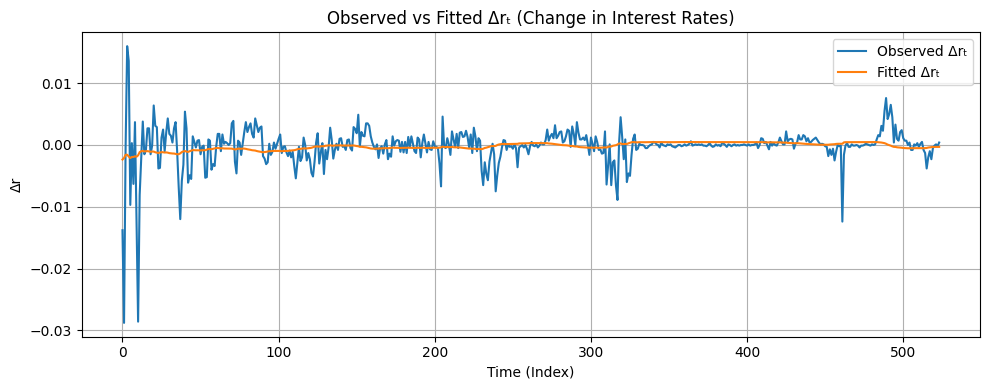

In [41]:
delta_r = r_tp1 - r_t
r_tp1_fitted = X @ beta_hat
fitted_delta = r_tp1_fitted - r_t

plt.figure(figsize=(10, 4))
plt.plot(delta_r, label="Observed Δrₜ", linewidth=1.5)
plt.plot(fitted_delta, label="Fitted Δrₜ", linewidth=1.5)
plt.title("Observed vs Fitted Δrₜ (Change in Interest Rates)")
plt.xlabel("Time (Index)")
plt.ylabel("Δr")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Observed vs Fitted Δrₜ (Change in Interest Rates)

This line plot compares the observed and fitted changes in interest rates (Δrₜ) over time. The observed Δrₜ represents the actual change from one period to the next, while the fitted Δrₜ is derived from the OLS model’s predicted values.

This visualisation helps evaluate how well the Vasicek model, estimated via OLS, captures the dynamics of interest rate changes. The closer the fitted line tracks the observed changes, the better the model fits the data.

While the model captures the general direction and scale of many fluctuations, differences between the two lines reveal model error and reinforce that the Vasicek framework simplifies complex interest rate dynamics.

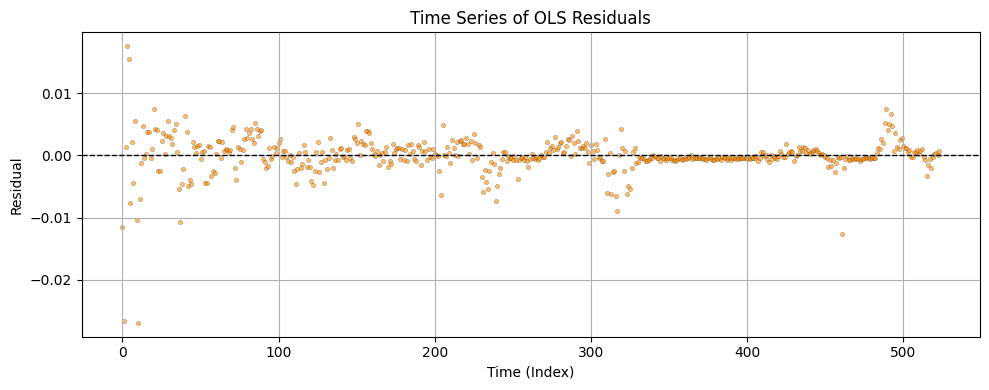

In [43]:
plt.figure(figsize=(10, 4))
plt.scatter(range(len(residuals)), residuals, s=10, alpha=0.6, color='darkorange', edgecolor='black', linewidth=0.2)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Time Series of OLS Residuals")
plt.xlabel("Time (Index)")
plt.ylabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.show()

Time Series of OLS Residuals

This scatter plot shows the residuals from the OLS estimation of the Vasicek model over time. Each point represents the difference between the actual and predicted interest rate at a given time step.

The goal of this plot is to assess whether the residuals behave like random noise, as assumed in classical linear regression. However, the spread of residuals is not uniform — there are visible periods of high and low variance. This suggests the presence of heteroscedasticity, meaning the variability of the error terms changes over time.

Such behavior indicates that the model may not fully capture time-varying volatility in interest rates, a known limitation of the standard Vasicek framework.

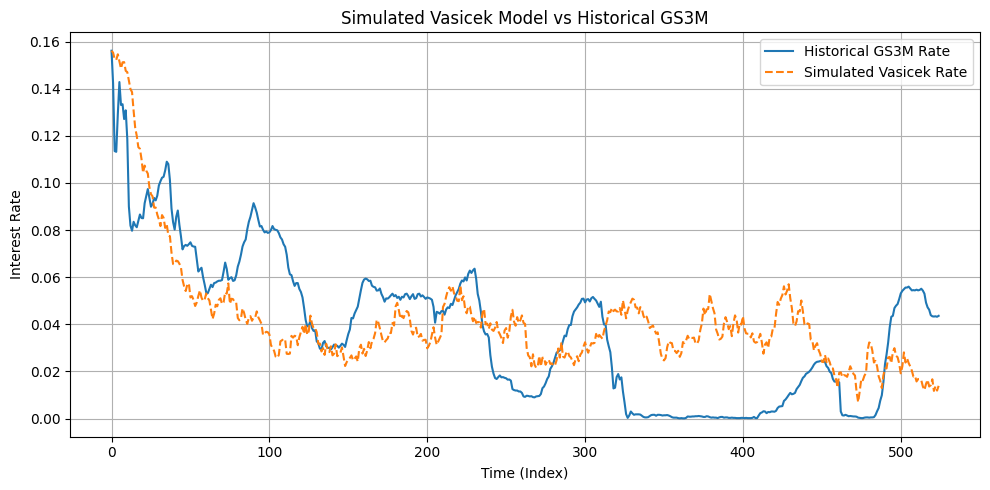

In [44]:
r0 = r[0]
T = len(r) - 1
simulated_rates = [r0]

np.random.seed(42)

for t in range(T):
    rt = simulated_rates[-1]
    dr = a * (b - rt) * dt + sigma * np.sqrt(dt) * np.random.normal()
    simulated_rates.append(rt + dr)

simulated_rates = np.array(simulated_rates)

plt.figure(figsize=(10, 5))
plt.plot(r, label="Historical GS3M Rate", linewidth=1.5)
plt.plot(simulated_rates, label="Simulated Vasicek Rate", linewidth=1.5, linestyle='--')
plt.title("Simulated Vasicek Model vs Historical GS3M")
plt.xlabel("Time (Index)")
plt.ylabel("Interest Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This plot compares the historical 3-month Treasury rate (GS3M) with a simulated interest rate path generated using the Vasicek model and OLS-estimated parameters. The simulation demonstrates how well the Vasicek model captures the mean-reverting behaviour of interest rates.


In [32]:
estimates_df = pd.DataFrame({
    'alpha': [alpha_ols],
    'beta': [beta_ols],
    'R_squared': [R2_ols],
    'a': [a_vasicek],
    'b': [b_vasicek],
    'sigma': [sigma_vasicek]
})

csv_path = "vasicek_estimates.csv"

estimates_df.to_csv(csv_path, index=False)
print(f"CSV saved to: {csv_path}")

CSV saved to: vasicek_estimates.csv
